# Predict Survival of the Titanic Passengers

You will use logistic regression method to predict if a passenger survived the Ill-fated voyage of the Titanic (1912). The passenger data includes name, age, ticket class, and sex.  If you watched the Titanic movie, you might recall that the first class passengers and women with children received preference to lifeboats.  Hence, gender, age, and ticket class could be the key predictors of survival.

## Table of Contents
- [Titanic Data](#Titanic_Data)
- [Load Libraries](#load_libraries)
- [Access data](#access_data)
- [Explore Data](#Explore)
- [Parse Data](#Parse)
- [Split Data into Training and Test set](#training_test)
- [Build Logistic Regression Model](#build_model)
- [Predict for Test data](#test_data)
- [Evaluate the Model](#evaluate_model)
- [ROC curve plot](#ROC_plot)

<a id="Titanic_Data"></a>
## Titanic Data 
You will analyze the random sample of the Titanic passengers data. The Dataset Source: [https://ww2.amstat.org/publications/jse/v3n3/datasets.dawson.html](https://ww2.amstat.org/publications/jse/v3n3/datasets.dawson.html)

 <table style="font-size: 16px; text-align: left;" width=100%>
  <tr>
  <td width=5% style="text-align: center; font-size: 16px">
   </td>
   <td width=11% style="text-align: left; font-size: 16px">
   <b>Variable</b>
   </td>
   <td width=53% style="text-align: left; font-size: 16px">
   <b> Description</b>
   </td>
    <td width=31% rowspan=7>
 
   <img src='https://www.khaskhabar.com/images/picture_image/3690-titanic-ship.jpg?raw=true'></img>
  
  </td>
  </tr>
  <tr>
   <td width=5% style="text-align: center; font-size: 16px">
     0 
   </td>
   <td width=11% style="text-align: left; font-size: 16px">
     Name 
   </td>
   <td width=53% style="text-align: left; font-size: 16px">
     Passenger's first and last name. 
   </td>
  
 </tr>
 <tr>
   <td style="text-align: center; font-size: 16px">
    1
  </td>
  <td style="text-align: left; font-size: 16px">
   PClass 
  </td>
  <td style="text-align: left; font-size: 16px">
   Ticket class (1st, 2nd, or 3rd) based on socio-economic status
  </td>
 </tr>
 <tr>
  <td style="text-align: center; font-size: 16px">
   2 
  </td>
  <td style="text-align: left; font-size: 16px">
  Age 
  </td>
  <td  style="text-align: left; font-size: 16px">
  Passenger's estimated age in years
  </td>
 </tr>
 <tr>
  <td style="text-align: center; font-size: 16px">
  3 
  </td>
  <td style="text-align: left; font-size: 16px">
  Sex 
  </td>
  <td style="text-align: left; font-size: 16px">
  male or female
  </td>
 </tr>
 <tr>
  <td style="text-align: center; font-size: 16px">
  4 
  </td>
  <td style="text-align: left; font-size: 16px">
  Survived
  </td>
  <td style="text-align: left; font-size: 16px">
  Indicates if the passenger survived the sinking of the Titanic (1=survived; 0=died)
  </td>
 </tr>
 <tr>
  <td style="text-align: center; font-size: 16px">
   5
  </td>
  <td style="text-align: left; font-size: 16px">
  PersonID 
  </td>
  <td style="text-align: left; font-size: 16px">
  Passenger's unique identifier
  </td>
 </tr>
</table>

<a id="load_libraries"></a>
## Load Libraries

The Spark and Python libraries that you need are preinstalled in the notebook environment and only need to be loaded.

Run the following cell to load the libraries you will work with in this notebook:

In [5]:
# PySpark Machine Learning Library
from pyspark.ml import Pipeline
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.feature import HashingTF, Tokenizer
from pyspark.sql import Row, SQLContext

import os
import sys
from pyspark import SparkConf
from pyspark import SparkContext
from pyspark.sql import SQLContext
from pyspark.sql.types import *

from pyspark.mllib.classification import LogisticRegressionWithSGD
from pyspark.mllib.regression import LabeledPoint
from numpy import array

from pyspark.ml.evaluation import MulticlassClassificationEvaluator
# Library for confusion matrix, precision, test error
from pyspark.mllib.evaluation import MulticlassMetrics
# Library For Area under ROC curve and Area under precision-recall curve
from pyspark.mllib.evaluation import BinaryClassificationMetrics

# Assign resources to the application
sqlContext = SQLContext(sc)

# packages for data analysis
import numpy as np
import pandas as pd

/opt/ibm/spark/python/lib/pyspark.zip/pyspark/sql/context.py:112: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.


In [6]:
# The data will be loaded into an array.
# This is the summary of the data structure, including the column position and name.
# The first filed starts from position 0. 

# 0 Name    -  Passenger first and last name.
# 1 PClass  -  Ticket class (1st, 2nd, or 3rd) based on Socio-Economic status
# 2 Age
# 3 Sex
# 4 Survived -  1 if the passenger survived;  0 if the passenger died
# 5 PersonID

# Label is a target variable. PersonInfo is a list of independent variables besides unique identifier

LabeledDocument = Row("PersonID", "PersonInfo", "label")

# Define a function that parses each raw in CSV file and returns an object of type LabeledDocument

def parseDocument(line):
    values = [str(x) for x in line.split(',')] 
    if (values[4]>'0'):
      Survived = 1.0
    else:
      Survived = 0.0
        
    textValue = str(values[1]) + " " + str(values[2])+" " + str(values[3])
    return LabeledDocument(values[5], textValue, Survived)

<a id="access_data"></a>
## Access Data
To read a file from Object Storage, you must setup the Spark configuration with your Object Storage credentials. 

To do this, click on the cell below and select the **Insert to code > Insert Spark Session DataFrame** function from the Files tab below the data file you want to work with.

<div class="alert alert-block alert-info">The following code contains the credentials for a file in your IBM Cloud Object Storage. </div>

In [7]:

import ibmos2spark

# @hidden_cell
# The following code accesses a file in your IBM Cloud Object Storage. It includes your credentials.
# You might want to remove those credentials before you share the notebook.

metadata = {
    'endpoint': 'https://s3.private.us-south.cloud-object-storage.appdomain.cloud',
    'service_id': 'iam-ServiceId-03d8a548-4ab7-49b7-a838-aeb6c3361d37',
    'iam_service_endpoint': 'https://iam.cloud.ibm.com/oidc/token',
    'api_key': 'fRvFmMME4TqenKiyVGLqhx2OaFDTqYkisC5zdCmh8WHD'
}

configuration_name = 'os_9047c094582b469abafd61f4a5efe4b4_configs'
cos = ibmos2spark.CloudObjectStorage(sc, metadata, configuration_name, 'bluemix_cos')
url = cos.url('Titanic.csv', 'apachesparktutorial-donotdelete-pr-pcnqnxgnxjduaw')

df_data_1 = spark.read \
    .format('org.apache.spark.sql.execution.datasources.csv.CSVFileFormat') \
    .option('header', 'true') \
    .option('inferSchema', 'true')\
    .load(url)
df_data_1.show(10)



+--------------------+------+----+------+--------+--------+
|                Name|PClass| Age|   Sex|Survived|PersonID|
+--------------------+------+----+------+--------+--------+
|Allen Miss Elisab...|   1st|29.0|female|       1|       1|
|Allison Miss Hele...|   1st| 2.0|female|       0|       2|
|Allison Mr Hudson...|   1st|30.0|  male|       0|       3|
|Allison Mrs Hudso...|   1st|25.0|female|       0|       4|
|Allison Master Hu...|   1st|0.92|  male|       1|       5|
|   Anderson Mr Harry|   1st|47.0|  male|       1|       6|
|Andrews Miss Korn...|   1st|63.0|female|       1|       7|
|Andrews Mr Thomas jr|   1st|39.0|  male|       0|       8|
|Appleton Mrs Edwa...|   1st|58.0|female|       1|       9|
|Artagaveytia Mr R...|   1st|71.0|  male|       0|      10|
+--------------------+------+----+------+--------+--------+
only showing top 10 rows



<a id="Explore"></a>
## Explore Data

In [8]:
print('Number of Passengers', df_data_1.count())

Number of Passengers 756


In [9]:
#Number of passengers who survived and number passengers who died
df_data_1.groupby('Survived').count().show()

+--------+-----+
|Survived|count|
+--------+-----+
|       1|  313|
|       0|  443|
+--------+-----+



+---------------+---+---+
|PClass_Survived|  0|  1|
+---------------+---+---+
|            2nd|116| 96|
|            1st| 87|139|
|            3rd|240| 78|
+---------------+---+---+



<Axes: title={'center': 'Survival by Socio-Economic Class'}, xlabel='PClass_Survived'>

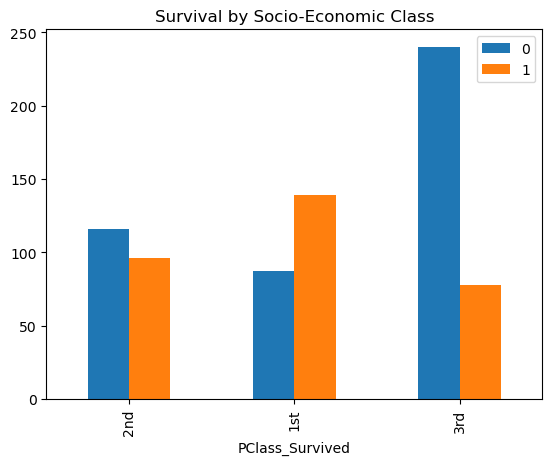

In [10]:
#Number of passengers who survived and number passengers who died by Socio-Economic class
import matplotlib.pyplot as plt
%matplotlib inline
df_data_1.crosstab('PClass', 'Survived').show()
df=df_data_1.crosstab('PClass', 'Survived').toPandas()
df.plot.bar(x="PClass_Survived", legend=True , title="Survival by Socio-Economic Class")

In [11]:
# Average age by survival outcome
# Convert Age data type from string to numeric.
pdf=df_data_1.toPandas()
pdf["Age"]=pd.to_numeric(pdf.Age)

df=sqlContext.createDataFrame(pdf)

PAge=df.groupby(['Survived'])\
.agg({"Age": "AVG"}).toPandas()
PAge

,Survived,avg(Age)
0,0,31.131670
1,1,29.359585


<Axes: title={'center': 'Age distribution'}, ylabel='Frequency'>

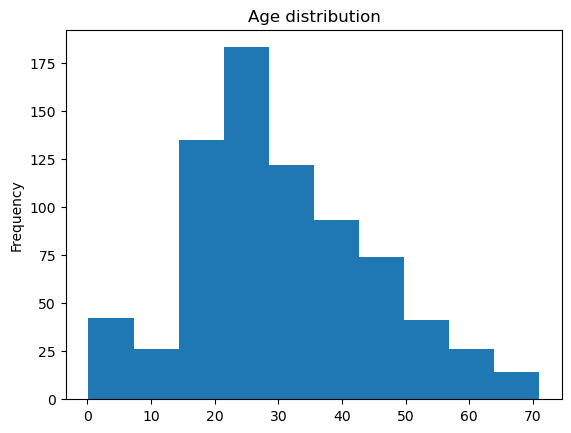

In [12]:
#Age distribution for all passengers
df.toPandas()["Age"].plot.hist(x="Age", title="Age distribution")

<a id="Parse"></a>
## Parse Data
Now let's load the data into a `Spark RDD` and output the number of rows and first 5 rows.
Each project you create has a bucket in your object storage. You may get the bucket name from the project Settings page. Replace the string `BUCKET` to the bucket name

In [13]:
data = sc.textFile(cos.url('Titanic.csv', 'apachesparktutorial-donotdelete-pr-pcnqnxgnxjduaw'))
print ("Total records in the data set:", data.count())
print ("The first 5 rows")
data.take(5)

Total records in the data set: 757
The first 5 rows


['Name,PClass,Age,Sex,Survived,PersonID',
 'Allen Miss Elisabeth Walton,1st,29,female,1,1',
 'Allison Miss Helen Loraine,1st,2,female,0,2',
 'Allison Mr Hudson Joshua Creighton,1st,30,male,0,3',
 'Allison Mrs Hudson JC (Bessie Waldo Daniels),1st,25,female,0,4']

Create DataFrame from RDD

In [14]:
#Parse and Load the data into a dataframe. The code calls the parsing function defined above
documents = data.filter(lambda s: "Name" not in s).map(parseDocument)
TitanicData = documents.toDF() # ToDataFrame
print ("Number of records: " + str(TitanicData.count()))
print ( "First 5 records: ")
TitanicData.take(5)

Number of records: 756
First 5 records: 


[Row(PersonID='1', PersonInfo='1st 29 female', label=1.0),
 Row(PersonID='2', PersonInfo='1st 2 female', label=0.0),
 Row(PersonID='3', PersonInfo='1st 30 male', label=0.0),
 Row(PersonID='4', PersonInfo='1st 25 female', label=0.0),
 Row(PersonID='5', PersonInfo='1st 0.92 male', label=1.0)]

<a id="training_test"></a>
## Split Data into Training and Test set

We divide the data into training and test set.  The training set is used to build the model to be used on future data, and the test set is used to evaluate the model.

In [15]:
# Divide the data into training and test set
(train, test) = TitanicData.randomSplit([0.8, 0.2])
print ("Number of records in the training set: " + str(train.count()))
print ("Number of records in the test set: " + str(test.count()))
# Output first 20 records in the training set
print ("First 20 records in the training set: ")
train.show()

Number of records in the training set: 596
Number of records in the test set: 160
First 20 records in the training set: 
+--------+-------------+-----+
|PersonID|   PersonInfo|label|
+--------+-------------+-----+
|       1|1st 29 female|  1.0|
|     100|  1st 46 male|  0.0|
|     101|  1st 25 male|  1.0|
|     102|1st 21 female|  1.0|
|     103|  1st 48 male|  1.0|
|     104|1st 49 female|  1.0|
|     105|  1st 45 male|  0.0|
|     107|  1st 55 male|  0.0|
|     108|1st 52 female|  1.0|
|     109|1st 24 female|  1.0|
|      11|  1st 47 male|  0.0|
|     110|1st 16 female|  1.0|
|     111|1st 44 female|  1.0|
|     112|1st 51 female|  1.0|
|     114|1st 35 female|  1.0|
|     115|  1st 35 male|  1.0|
|     116|  1st 38 male|  1.0|
|     117|1st 35 female|  1.0|
|     118|1st 50 female|  0.0|
|     119|  1st 49 male|  1.0|
+--------+-------------+-----+
only showing top 20 rows



<a id="build_model"></a>
## Build Logistic Regression Model

We use the Pipeline of SparkML to build the Logistic Regression Model

In [16]:
# set up Logistic Regression using Pipeline of SparkML
tokenizer = Tokenizer(inputCol="PersonInfo", outputCol="words")
hashingTF = HashingTF(inputCol=tokenizer.getOutputCol(), outputCol="features")
lr = LogisticRegression(maxIter=10, regParam=0.01)
pipeline = Pipeline(stages=[tokenizer, hashingTF, lr])

In [17]:
# set up Logistic Regression Model
# the stages are executed in order
model = pipeline.fit(train)
#[stage.coefficients for stage in model.stages if hasattr(stage, "coefficients")]
# model.stages[2].intercept

<a id="test_data"></a>
## Predict for Test data

In [18]:
# Make predictions for test data and print columns of interest
prediction = model.transform(test)
selected = prediction.select("PersonInfo", "prediction", "probability")
for row in selected.collect():
    print (row)

Row(PersonInfo='1st 71 male', prediction=0.0, probability=DenseVector([0.9576, 0.0424]))
Row(PersonInfo='1st 36 female', prediction=1.0, probability=DenseVector([0.0336, 0.9664]))
Row(PersonInfo='1st 42 male', prediction=0.0, probability=DenseVector([0.7865, 0.2135]))
Row(PersonInfo='1st 19 female', prediction=1.0, probability=DenseVector([0.0299, 0.9701]))
Row(PersonInfo='1st 46 male', prediction=0.0, probability=DenseVector([0.8983, 0.1017]))
Row(PersonInfo='1st 42 male', prediction=0.0, probability=DenseVector([0.7865, 0.2135]))
Row(PersonInfo='1st 40 female', prediction=1.0, probability=DenseVector([0.1823, 0.8177]))
Row(PersonInfo='1st 65 male', prediction=0.0, probability=DenseVector([0.5892, 0.4108]))
Row(PersonInfo='1st 58 male', prediction=0.0, probability=DenseVector([0.6742, 0.3258]))
Row(PersonInfo='1st 23 female', prediction=1.0, probability=DenseVector([0.1148, 0.8852]))
Row(PersonInfo='1st 36 male', prediction=1.0, probability=DenseVector([0.3832, 0.6168]))
Row(PersonInf

In [19]:
#Tabulate the predicted outcome
prediction.select("prediction").groupBy("prediction").count().show(truncate=False)

+----------+-----+
|prediction|count|
+----------+-----+
|0.0       |109  |
|1.0       |51   |
+----------+-----+



In [20]:
#Tabulate the actual outcome
prediction.select("label").groupBy("label").count().show(truncate=False)

+-----+-----+
|label|count|
+-----+-----+
|0.0  |99   |
|1.0  |61   |
+-----+-----+



In [21]:
# This table shows:
# 1. The number of passengers who survived predicted as died
# 2. The number of passengers who survived predicted as survived
# 3. The number of passengers who died predicted as died
# 4. The number of passengers who died predicted as survived

prediction.crosstab('label', 'prediction').show()

+----------------+---+---+
|label_prediction|0.0|1.0|
+----------------+---+---+
|             1.0| 23| 38|
|             0.0| 86| 13|
+----------------+---+---+



<a id="evaluate_model"></a>
## Evaluate the Model

We evaluate the model on a training set and on a test set.  The purpose is to measure the model's predictive accuracy, including the accuracy for new data.

In [22]:
# Evaluate the Logistic Regression model on a training set
# Select (prediction, true label) and compute test error
pred_lr=model.transform(train).select("prediction", "label")
eval_lr=MulticlassClassificationEvaluator (
    labelCol="label", predictionCol="prediction", metricName="accuracy")
accuracy_lr=eval_lr.evaluate(pred_lr)
# create RDD
predictionAndLabels_lr=pred_lr.rdd
metrics_lr=MulticlassMetrics(predictionAndLabels_lr)
precision_lr=metrics_lr.precision(1.0)
recall_lr=metrics_lr.recall(1.0)
f1Measure_lr = metrics_lr.fMeasure(1.0, 1.0)
print ("Model evaluation for the training data")
print ("Accuracy = %s" %accuracy_lr)
print ("Error = %s" % (1-accuracy_lr))
print ("Precision = %s" %precision_lr)
print ("Recall = %s" %recall_lr)
print("F1 Measure = %s" % f1Measure_lr)

/opt/ibm/spark/python/lib/pyspark.zip/pyspark/sql/context.py:157: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.


Model evaluation for the training data
Accuracy = 0.8355704697986577
Error = 0.16442953020134232
Precision = 0.826271186440678
Recall = 0.7738095238095238
F1 Measure = 0.7991803278688525


In [23]:
# Evaluate the Logistic Regression model on a test set
# Select (prediction, true label) and compute test error
pred_lr=model.transform(test).select("prediction", "label")
eval_lr=MulticlassClassificationEvaluator (
    labelCol="label", predictionCol="prediction", metricName="accuracy")
accuracy_lr=eval_lr.evaluate(pred_lr)
# create RDD
predictionAndLabels_lr=pred_lr.rdd
metrics_lr=MulticlassMetrics(predictionAndLabels_lr)
precision_lr=metrics_lr.precision(1.0)
recall_lr=metrics_lr.recall(1.0)
f1Measure_lr = metrics_lr.fMeasure(1.0, 1.0)
print ("Model evaluation for the test data")
print ("Accuracy = %s" %accuracy_lr)
print ("Error = %s" % (1-accuracy_lr))
print ("Precision = %s" %precision_lr)
print ("Recall = %s" %recall_lr)
print ("F1 Measure = %s" % f1Measure_lr)

Model evaluation for the test data
Accuracy = 0.775
Error = 0.22499999999999998
Precision = 0.7450980392156863
Recall = 0.6229508196721312
F1 Measure = 0.6785714285714286


In [24]:
bin_lr=BinaryClassificationMetrics(predictionAndLabels_lr)

# Area under precision-recall curve
print("Area under PR = %s" % bin_lr.areaUnderPR)
# Area under Receiver operating characteristic curve
print("Area under ROC = %s" % bin_lr.areaUnderROC)

Area under PR = 0.6765037367405979
Area under ROC = 0.7458188441795


<a id="ROC_plot"></a>
## ROC Curve Plot
The Binary Logistic Regression method returns the pyspark.ml.classification.BinaryLogisticRegressionTrainingSummary object. We may use the roc method to obtain the coordinates of the points on Receiver operating characteristic (ROC) curve.  The coordinates are stored in a Dataframe with two fields FPR=false positive rate and TPR=true positive rate

In [25]:
#The firt 20 ROC curve points
model.stages[2].summary.roc.show()

+---+--------------------+
|FPR|                 TPR|
+---+--------------------+
|0.0|                 0.0|
|0.0|0.003968253968253968|
|0.0|0.011904761904761904|
|0.0|0.015873015873015872|
|0.0| 0.01984126984126984|
|0.0|0.027777777777777776|
|0.0|0.031746031746031744|
|0.0| 0.03571428571428571|
|0.0| 0.03968253968253968|
|0.0|0.047619047619047616|
|0.0| 0.05555555555555555|
|0.0| 0.05952380952380952|
|0.0| 0.07142857142857142|
|0.0| 0.07539682539682539|
|0.0| 0.08333333333333333|
|0.0|  0.0873015873015873|
|0.0| 0.09126984126984126|
|0.0| 0.09523809523809523|
|0.0|  0.0992063492063492|
|0.0| 0.10317460317460317|
+---+--------------------+
only showing top 20 rows



<Axes: xlabel='FPR'>

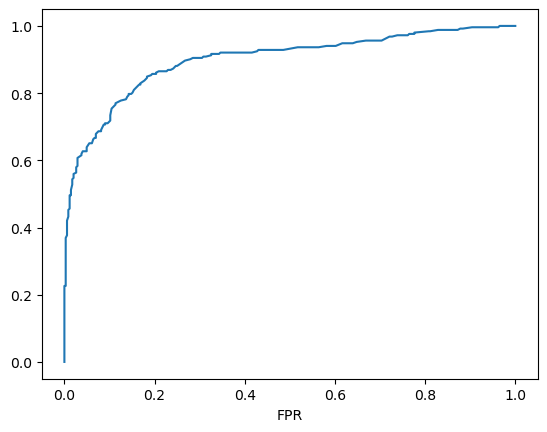

In [26]:
import matplotlib.pyplot as plt
%matplotlib inline
ROC=model.stages[2].summary.roc
df=ROC.toPandas()

df.plot(x='FPR', y='TPR', legend=False)